# MCMC sampling functionality using simulated data

A not-very-polished demonstration of Markov chain Monte Carlo (MCMC) sampling for ab initio estimation of volume and pose variables, in the spirit of [Lederman et al, 2020](https://iopscience.iop.org/article/10.1088/1361-6420/ab5ede/meta), although only for homogeneous reconstruction.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax import config
import time
import mrcfile
from pyem import star

from simplecryoem.ab_initio import ab_initio_mcmc
from simplecryoem.forwardmodel import (
    project,
    apply_shifts_and_ctf,
    Slice,
    rotate_and_interpolate,
)
from simplecryoem.optimization import (
    Loss,
    GradV,
    sgd,
    get_sgd_vol_ops,
    conjugate_gradient,
    get_cg_vol_ops,
)
from simplecryoem.sampling import mcmc_sampling, proposal_hmc, CryoProposals
from simplecryoem.fsc import calc_fsc, shell_points_used, points_orientations_tri
from simplecryoem.utils import (
    volume_fourier,
    volume_comp,
    mip_y,
    mip_z,
    create_3d_mask,
    generate_uniform_orientations,
    generate_uniform_orientations_jax,
    generate_gaussian_shifts,
    generate_uniform_shifts,
    crop_fourier_images,
    crop_fourier_volume,
    plot_angles,
    wrap_around_distance_2d_array,
)

2024-10-12 17:14:41.694554: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

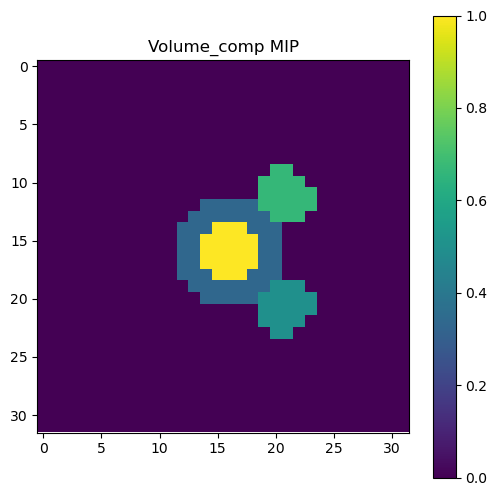

In [3]:
nx = 32
shape = np.array([nx, nx, nx])
dimensions = np.array([20, 20, 20])
pixel_size = dimensions[0] / shape[0]

# A volume with components
centres = np.array([[0, 0, 0], [3, 3, 0], [3, -3, 0], [0, 0, 3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10, 15, 20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
# plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title("Volume_comp MIP")

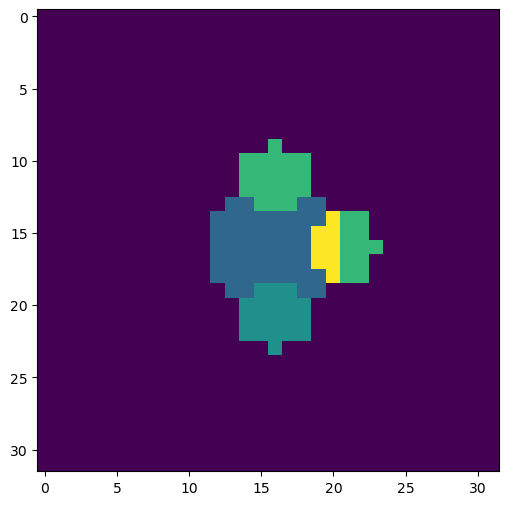

In [4]:
mip_y(vol)

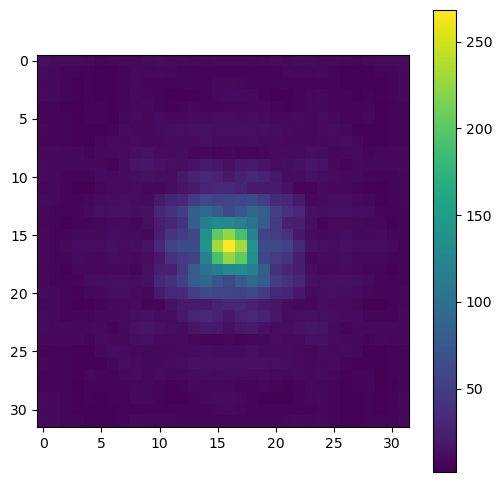

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier))))
plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("comparisons/data/pyem.star", keep_index=False)
dfiter = df.iterrows()
_, p = next(dfiter)

# ctf_params = {'def1'  : p[star.Relion.DEFOCUSU],
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE],
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC],
#              'cs'    : p[star.Relion.CS],
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array(
    [
        p[star.Relion.DEFOCUSU],
        p[star.Relion.DEFOCUSV],
        p[star.Relion.DEFOCUSANGLE],
        p[star.Relion.PHASESHIFT],
        p[star.Relion.VOLTAGE],
        p[star.Relion.AC],
        p[star.Relion.CS],
        0,
        2 * pixel_size,
    ]
)

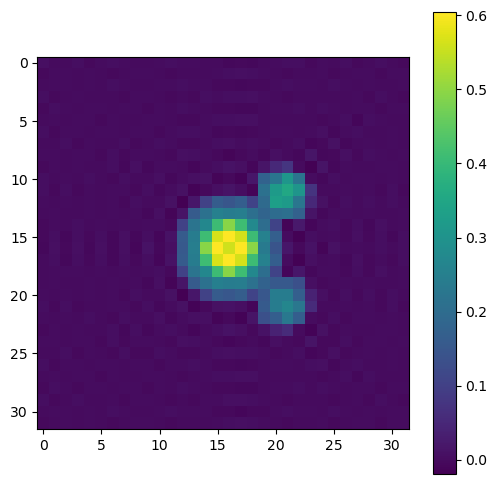

In [7]:
radius = 0.8
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'nn')

#slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(
#    project, x_grid, mask, "nn"
#)
s = 17
img = slice_obj.slice(0.1 * vol_fourier, [0, 0, 0], [0, 0], jnp.array([None]))
img_r = jnp.fft.fftshift(jnp.real(jnp.fft.ifft2((img.reshape([nx, nx])))))
plt.imshow(img_r)
plt.colorbar()

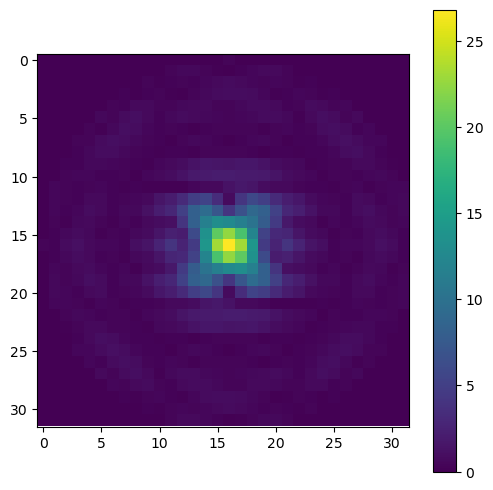

In [8]:
img_f0 = jnp.fft.fftshift(img.reshape([nx, nx]))
plt.imshow(jnp.abs(img_f0))
plt.colorbar()

Generate projections (in Fourier domain)

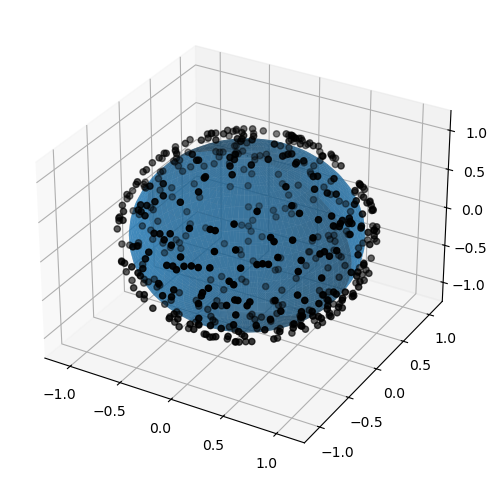

In [9]:
# Orientations
N = 5000

# s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
# jnp.array(np.random.rand(N,3))*jnp.pi*2

# angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
# angles_true = s*np.random.randn(int(N),3)
# angles_true = np.concatenate([s*np.random.randn(2250,3),
#                             s*np.random.randn(2250,3)+np.pi*2/3,
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
# np.random.shuffle(angles_true)
# angles_true = jnp.array(angles_true)

# angles_true = np.zeros([N,3])
# angles_true[:,1] = s*np.random.randn(N) - np.pi/2
# angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

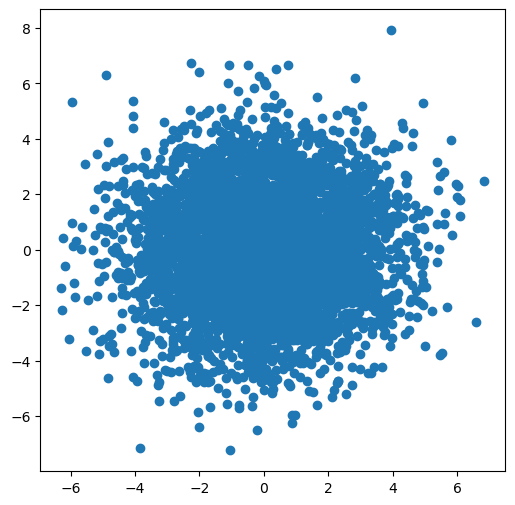

In [10]:
# Shifts
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
key, subkey = random.split(key)
# shifts_true = generate_uniform_shifts(key, N, pixel_size*nx/2)
shifts_true = generate_gaussian_shifts(key, N, pixel_size * nx / 10)

# shifts_true = jnp.zeros([N,3])

plt.scatter(shifts_true[:, 0], shifts_true[:, 1])

SNR = 0.15678984665785867
sigma = 37.84951113740295


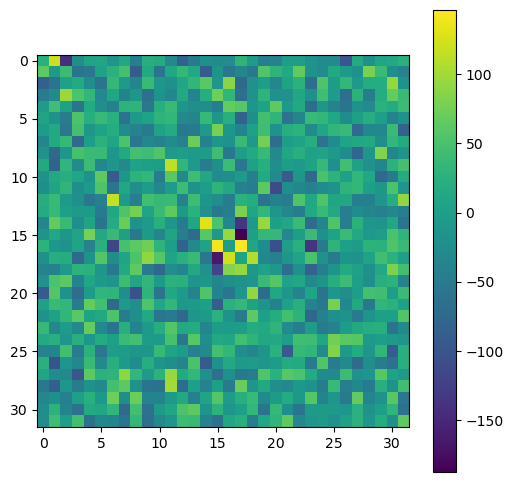

In [11]:
radius = 0.8
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
# mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'nn')

img0 = slice_obj.slice(vol_fourier, [0, 0, 0], [0, 0], ctf_params0)


ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_obj.slice_array(vol_fourier, angles_true, shifts_true, ctf_params)

# If too many images which don't fit in the gpu memory, do this:
# imgs = jnp.array([slice_func(vol_fourier, angles_true[i], shifts_true[i], ctf_params0) for i in range(N)])

norm0sq = jnp.real(jnp.sum(jnp.conj(imgs) * imgs))

# Noise
sigma = 0.2 * jnp.max(jnp.abs(img0))
imgs += (np.random.randn(N, nx * nx) + 1j * np.random.randn(N, nx * nx)) * sigma

norm1sq = jnp.real(jnp.sum(jnp.conj(imgs) * imgs))

# print(time.time()-start)

# SNR
print("SNR =", norm0sq / norm1sq)
print("sigma =", sigma)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[101].reshape(nx, nx))))
plt.colorbar()

### Crop images and volume:

In [12]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx * nx)
    # imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

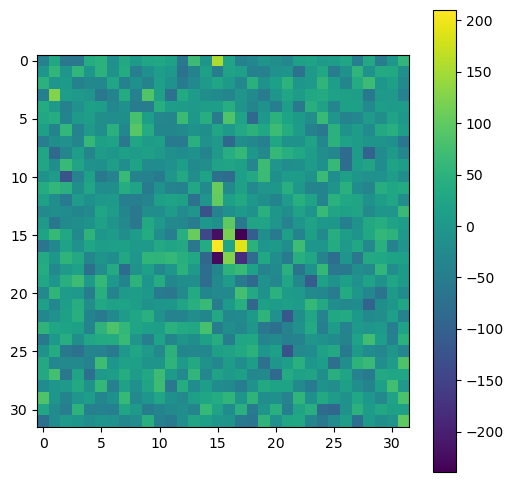

In [13]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx, nx))))
plt.colorbar()

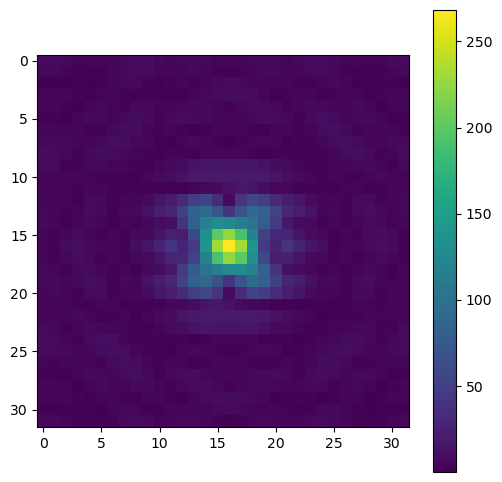

In [14]:
# mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:, :, 0]))))
plt.colorbar()

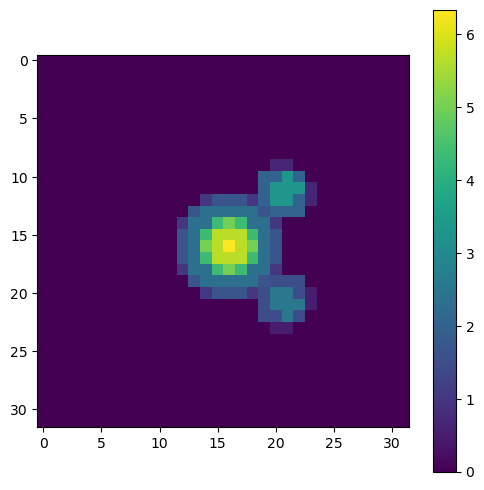

In [15]:
# mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:, :, 0]))))
plt.colorbar()

### Loss functions for the new dimension

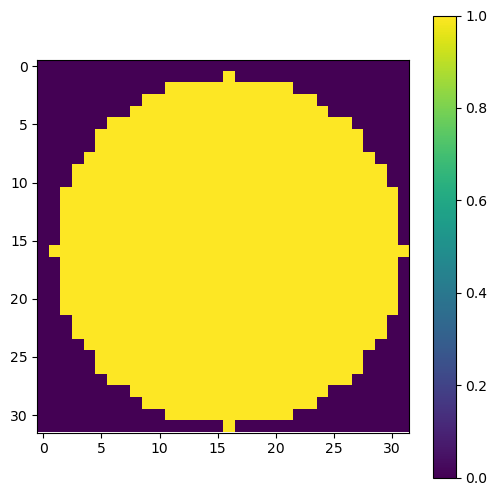

In [16]:
alpha = 0.01
# alpha = 1/N

#radius = 0.2 # for nx =8
# radius = 0.4 # for nx=16
radius = 0.75  # for nx=32
# radius = 1.6 # for nx=64
# radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0, 0, 0), radius)
mip_z(jnp.fft.fftshift(mask))
plt.colorbar()

slice_obj = Slice(x_grid, mask, project, interp_method = 'tri')
loss_obj = Loss(slice_obj, alpha=alpha)
grad_obj = GradV(loss_obj)

In [17]:
sigma_noise = jnp.ones(nx * nx) * sigma

In [18]:
start = time.time()
ll = loss_obj.loss_batched(
    vol_fourier,
    angles_true[:20],
    shifts_true[:20],
    ctf_params[:20],
    imgs[:20],
    sigma_noise,
)
print(time.time() - start)
print(ll.shape)

1.0899102687835693
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [19]:
start = time.time()
ll = grad_obj.grad_loss_volume(
    np.random.randn(nx, nx, nx),
    angles_true[0],
    shifts_true[0],
    ctf_params[0],
    imgs[0],
    sigma_noise,
)
print(time.time() - start)
print(ll.shape)

0.938978910446167
(32, 32, 32)


In [20]:
batch_size = N
idx = np.random.default_rng().choice(N, size=batch_size, replace=False)

start = time.time()
ll = grad_obj.grad_loss_volume_sum(
    np.random.randn(nx, nx, nx),
    angles_true[idx],
    shifts_true[idx],
    ctf_params[idx],
    imgs[idx],
    sigma_noise,
)
print(time.time() - start)
print(ll.shape)

1.7063274383544922
(32, 32, 32)


### Set up the CryoProposals object for MCMC sampling

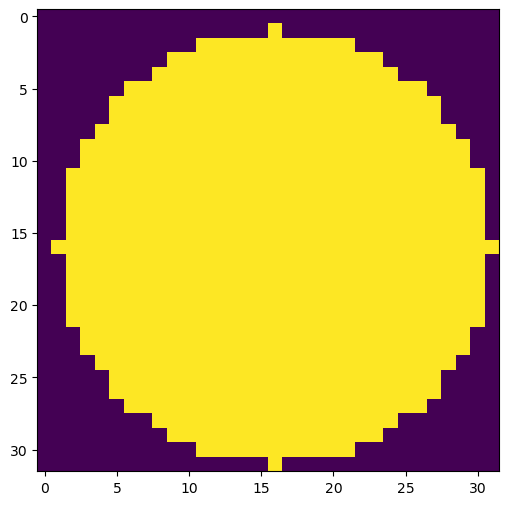

In [21]:
alpha0 = 0
B = pixel_size * nx / 10
B_list = jnp.array([B])
radius_mask = 0.75  # for nx=32
mask = create_3d_mask(x_grid, (0, 0, 0), radius_mask)
dt_list = jnp.array([0.5])
L_hmc = 10
M = 1

slice_obj = Slice(x_grid, mask, project, interp_method = 'tri')
loss_obj = Loss(slice_obj, alpha=alpha)
grad_obj = GradV(loss_obj)

cryo_proposals = CryoProposals(1, B, B_list, dt_list, L_hmc, M, slice_obj, loss_obj, grad_obj)

mip_z(jnp.fft.fftshift(mask))

### MCMC - volume

In [22]:
def plot_true_vs_estimated(vol_true, vol_estimated):
    plt.rcParams["figure.figsize"] = 16, 16
    plt.subplot(2, 2, 1)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_true[:, :, 0])))
    plt.colorbar()
    plt.title("True")
    plt.subplot(2, 2, 2)
    plt.imshow(jnp.abs(jnp.fft.fftshift(vol_estimated[:, :, 0])))
    plt.colorbar()
    plt.title("Estimated")
    plt.subplot(2, 2, 3)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_true[:, :, 0]))))
    plt.colorbar()
    plt.title("True")
    plt.subplot(2, 2, 4)
    plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_estimated[:, :, 0]))))
    plt.colorbar()
    plt.title("Estimated")

    plt.rcParams["figure.figsize"] = 8, 8

In [23]:
N_mc_samples = 200

key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
v0 = jnp.array(np.random.randn(nx, nx, nx) + 1j * np.random.randn(nx, nx, nx))

proposal_params = {
    'angles' : angles_true,
    'shifts' : shifts_true,
    'ctf_params' : ctf_params,
    'imgs' : imgs
}
t0 = time.time()
v_hmc_mean, r_hmc, v_hmc_samples = mcmc_sampling(
    key, 
    cryo_proposals.proposal_vol, 
    v0, 
    N_mc_samples, 
    proposal_params,
    verbose=True,
    iter_display=10
)
print((time.time() - t0) / N_mc_samples)
v_hmc_mean = v_hmc_mean * mask

  MCMC sample 10, posterior val = -1514360.2350399788, a = 1.0
  MCMC sample 20, posterior val = -1514139.4984457006, a = 0.9228196623894174
  MCMC sample 30, posterior val = -1514128.9143497234, a = 1.0
  MCMC sample 40, posterior val = -1514271.8874723103, a = 1.0
  MCMC sample 50, posterior val = -1514080.8247942426, a = 0.9902790508296194
  MCMC sample 60, posterior val = -1513957.4736263794, a = 1.0
  MCMC sample 70, posterior val = -1514018.0533433028, a = 1.0
  MCMC sample 80, posterior val = -1513975.8782338253, a = 0.9969726637921706
  MCMC sample 90, posterior val = -1514101.04476806, a = 1.0
  MCMC sample 100, posterior val = -1513879.9671968843, a = 1.0
  MCMC sample 110, posterior val = -1513976.5215880522, a = 0.9174719842144959
  MCMC sample 120, posterior val = -1514120.0771614139, a = 1.0
  MCMC sample 130, posterior val = -1513977.1364745924, a = 0.9124368353701088
  MCMC sample 140, posterior val = -1513942.6171133786, a = 0.8658302331392274
  MCMC sample 150, poster

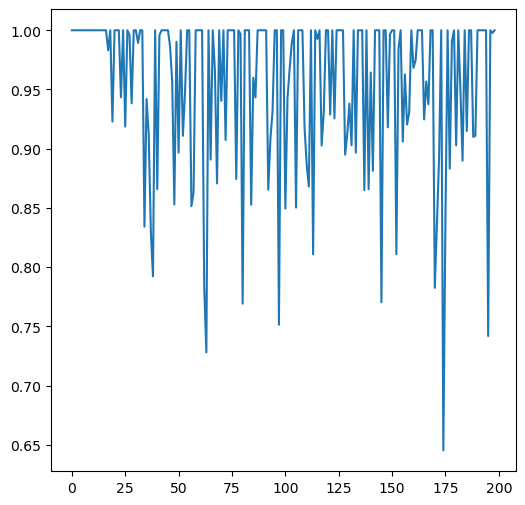

In [24]:
plt.plot(r_hmc)

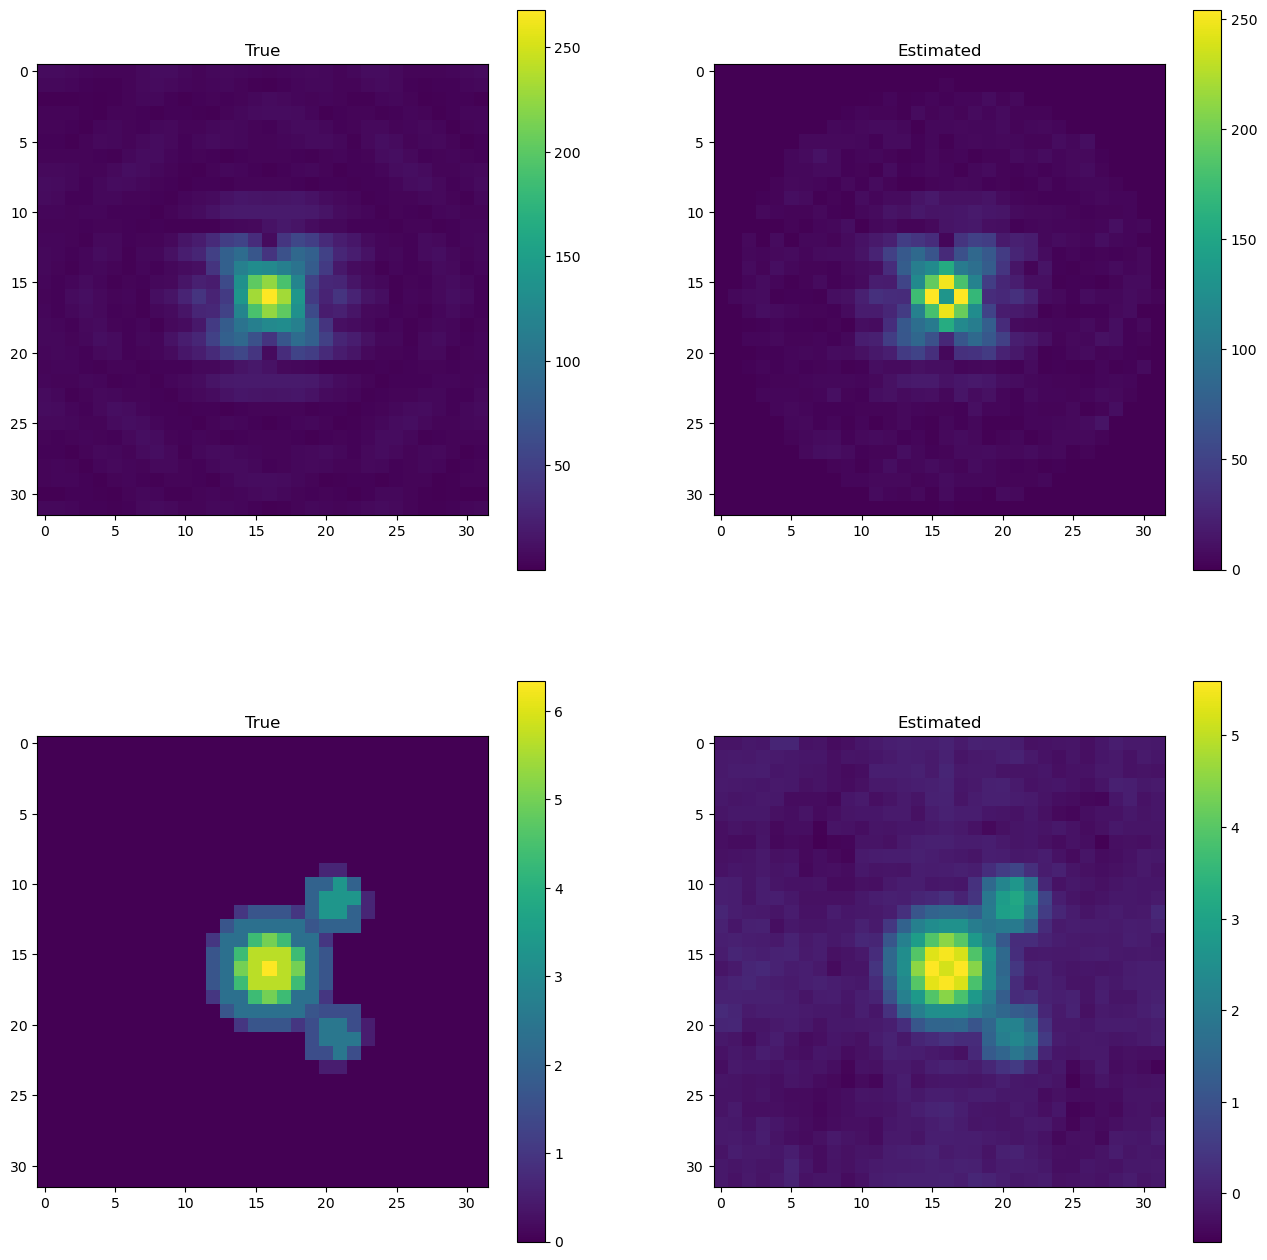

In [25]:
plot_true_vs_estimated(vol_fourier, v_hmc_mean)

In [26]:
print(loss_obj.loss_sum(vol_fourier, angles_true, shifts_true, ctf_params, imgs, 1))
print(loss_obj.loss_sum(v_hmc_mean, angles_true, shifts_true, ctf_params, imgs, 1))

1503255.5762066809
1498054.19434694


### MCMC - poses

### Orientations

In [27]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_mc_samples = 1001

angles0 = generate_uniform_orientations_jax(key, angles_true)
angles_proposal_params = {
    'v' : vol_fourier,
    'shifts' : shifts_true,
    'ctf_params' : ctf_params,
    'imgs' : imgs
}

_, r_angles, angles_samples = mcmc_sampling(
    key, 
    cryo_proposals.proposal_orientations_uniform, 
    angles0, 
    N_mc_samples, 
    angles_proposal_params,
    N_batch=N,
    verbose=True,
    iter_display=20
)

print(time.time() - t0)

angles_rec = angles_samples[0]

  MCMC sample 20, posterior val = -1524428.3693818643
  MCMC sample 40, posterior val = -1516367.2977897043
  MCMC sample 60, posterior val = -1512069.9642407678
  MCMC sample 80, posterior val = -1509116.0962876375
  MCMC sample 100, posterior val = -1506914.3043875126
  MCMC sample 120, posterior val = -1505126.8096320154
  MCMC sample 140, posterior val = -1503862.0482555176
  MCMC sample 160, posterior val = -1502672.8417423996
  MCMC sample 180, posterior val = -1501527.7680566758
  MCMC sample 200, posterior val = -1500597.5900396241
  MCMC sample 220, posterior val = -1499793.0800511425
  MCMC sample 240, posterior val = -1499114.979632389
  MCMC sample 260, posterior val = -1498437.2738839386
  MCMC sample 280, posterior val = -1497899.790611155
  MCMC sample 300, posterior val = -1497353.6209772846
  MCMC sample 320, posterior val = -1496878.5387203926
  MCMC sample 340, posterior val = -1496410.2308781461
  MCMC sample 360, posterior val = -1496010.9471898656
  MCMC sample 38

In [28]:
print(jnp.max(jnp.abs(loss_obj.loss_sum(vol_fourier, angles0, shifts_true, ctf_params, imgs, 1))))
print(jnp.max(jnp.abs(loss_obj.loss_sum(vol_fourier, angles_rec, shifts_true, ctf_params, imgs, 1))))
print(jnp.max(jnp.abs(loss_obj.loss_sum(vol_fourier, angles_true, shifts_true, ctf_params, imgs, 1))))

1604996.2153733922
1512137.9121033326
1503255.5762066809


### Shifts

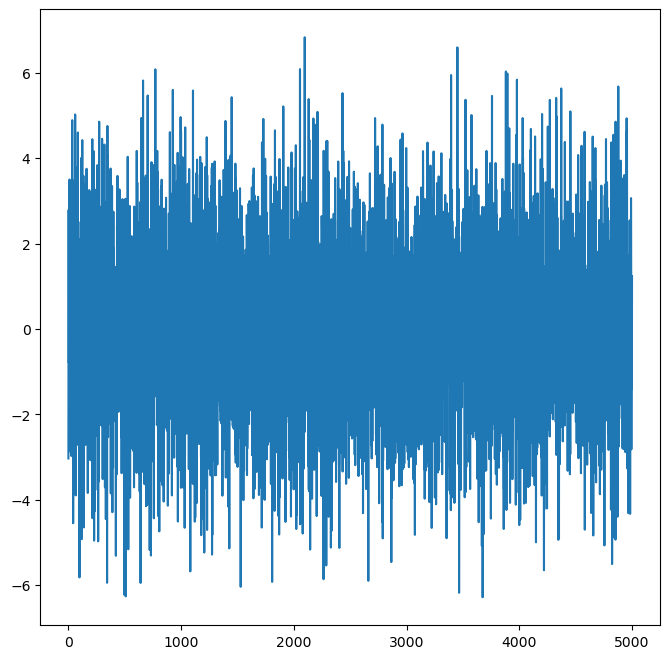

In [29]:
plt.plot(shifts_true[:,0])

In [30]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))
N_mc_samples = 1001

shifts0 = generate_gaussian_shifts(key, N, cryo_proposals.B)
proj = slice_obj.rotate_and_interpolate_vmap(vol_fourier, angles_true)
shifts_proposal_params = {
    'v' : vol_fourier,
    'proj' : proj,
    'ctf_params' : ctf_params,
    'imgs' : imgs
}

t0 = time.time()

_, r_shifts, shifts_samples = mcmc_sampling(
    key, 
    cryo_proposals.proposal_shifts_local, 
    shifts0, 
    N_mc_samples, 
    shifts_proposal_params,
    N_batch=N,
    verbose=True,
    iter_display=20
)

print(time.time() - t0)

shifts_rec = shifts_samples[0]

  MCMC sample 20, posterior val = -1547061.042586057
  MCMC sample 40, posterior val = -1515612.4260083458
  MCMC sample 60, posterior val = -1506519.494550369
  MCMC sample 80, posterior val = -1501902.937486123
  MCMC sample 100, posterior val = -1499319.1723754501
  MCMC sample 120, posterior val = -1497222.9972918339
  MCMC sample 140, posterior val = -1496022.403121878
  MCMC sample 160, posterior val = -1494899.7287991617
  MCMC sample 180, posterior val = -1493928.6367450603
  MCMC sample 200, posterior val = -1493445.0446268476
  MCMC sample 220, posterior val = -1492913.2739777742
  MCMC sample 240, posterior val = -1492496.7561358395
  MCMC sample 260, posterior val = -1491982.5931603492
  MCMC sample 280, posterior val = -1491718.5996899498
  MCMC sample 300, posterior val = -1491343.0255147736
  MCMC sample 320, posterior val = -1491023.4606330185
  MCMC sample 340, posterior val = -1490739.4535807648
  MCMC sample 360, posterior val = -1490411.8276658827
  MCMC sample 380,

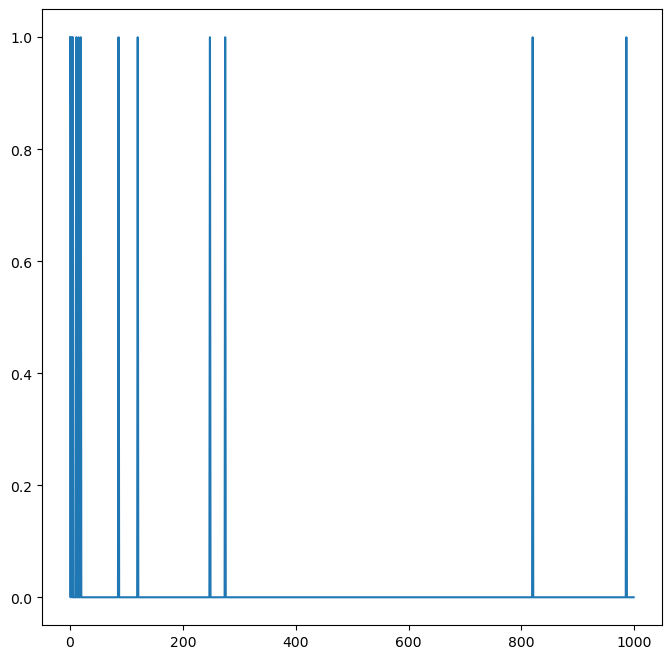

In [31]:
plt.plot(r_shifts[:,10])

mean shift0 error = 1.6314189230527298 in [ -2.0 , 2.0 ]^2
mean shift error = 0.49633397134448964 in [ -2.0 , 2.0 ]^2


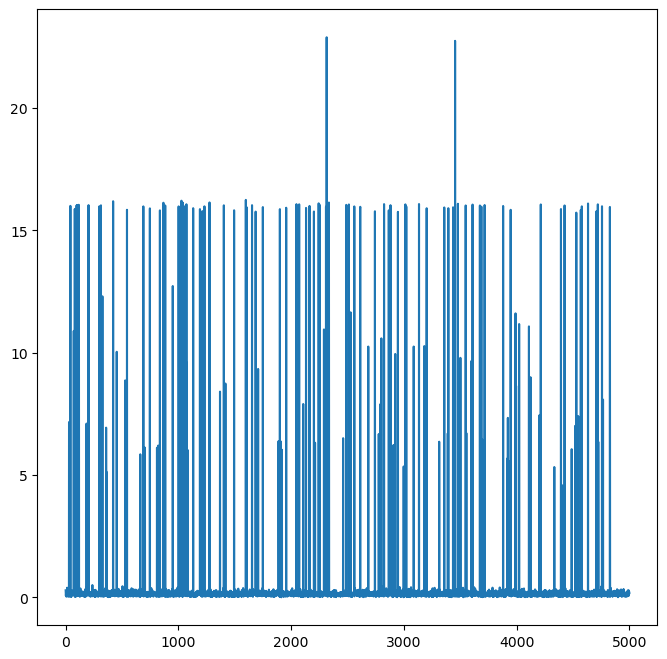

In [32]:
shifts0_err = wrap_around_distance_2d_array(shifts_true, shifts0, B)
shifts_err = wrap_around_distance_2d_array(shifts_true, shifts_rec, B)
print("mean shift0 error =", jnp.mean(shifts0_err), "in [", -B, ",", B, "]^2")
print("mean shift error =", jnp.mean(shifts_err), "in [", -B, ",", B, "]^2")
plt.plot(shifts_err)

### Ab initio reconstuction using MCMC sampling: volume+orientations+shifts

An example of setting the required parameters for ab initio reconstruction, although this example volume lacks distinct features in most orientations so its ab initio reconstruction is particularly difficult.

In [ ]:
key = random.PRNGKey(int(jnp.floor(np.random.rand() * 1000)))

# It will stop when nx_iter=nx anyway, so setting N_iter large enough
N_iter = 200
N_batch = 1

dr = 0.05
radius = 0.2
alpha = 1e-7

sgd_batch_size = 500
learning_rate = 1

vol0 = None
angles0 = None
shifts0 = None

N_samples_vol = 501
N_samples_angles_global = 1001
N_samples_angles_local = 501
N_samples_shifts_global = 501
N_samples_shifts_local = 1001

# imgs_batch stays in RAM and only the current batch is processed on the GPU
imgs_batch = np.array(np.array_split(imgs, N_batch))
ctf_params_batch = jnp.array(np.array_split(ctf_params, N_batch))

eps_vol = 2e-5

# HMC params
dt_list = jnp.array([0.1, 0.5, 1, 5])
L = 10

# boundary for sampling shifts in [-B, B]^2
B = pixel_size * nx / 10

out_dir = "../data/ab_initio/"
imgs = imgs.reshape([N, nx * nx])
v_rec, angles_rec, shifts_rec = ab_initio_mcmc(
    key,
    imgs_batch,
    sigma_noise,
    ctf_params_batch,
    x_grid,
    vol0,
    angles0,
    shifts0,
    N_iter,
    learning_rate,
    sgd_batch_size,
    N_samples_vol,
    N_samples_angles_global,
    N_samples_angles_local,
    N_samples_shifts_global,
    N_samples_shifts_local,
    dt_list_hmc=dt_list,
    L_hmc=L,
    radius0=radius,
    dr = dr,
    alpha=alpha,
    eps_vol=eps_vol,
    B=B,
    B_list=jnp.array([B]),
    freq_marching_step_iters=4,
    interp_method="tri",
    opt_vol_first=True,
    verbose=True,
    save_to_file=False,
)

Fourier radius: 0.8
Minibatch factor: None
Starting radius: 0.2
Frequency marching step size: 0.05
Number of frequency marching steps: 13
Number of iterations: 52
B = 2.0
B_list = [2.]
------------------------------------

Initialitsing volume
Epoch 1/501 

100%|█| 10/10 [00:03<00:00,  3.10it/s, eta=1.000e+00, grad=3.549e-0


  |Grad| = 3.611e-02
  Loss = 1.21505195e+03
  eta = 1
  alpha = 1e-10
Epoch 101/501 

100%|█| 10/10 [00:00<00:00, 80.90it/s, eta=1.000e+00, grad=3.002e-0

  |Grad| = 3.041e-02
  Loss = 1.19990872e+03
  eta = 1
  alpha = 1e-10


Epoch 201/501 

100%|█| 10/10 [00:00<00:00, 99.26it/s, eta=1.000e+00, grad=2.683e-0

  |Grad| = 2.629e-02
  Loss = 1.18887809e+03
  eta = 1
  alpha = 1e-10


Epoch 301/501 

100%|█| 10/10 [00:00<00:00, 100.70it/s, eta=1.000e+00, grad=2.256e-

  |Grad| = 2.240e-02
  Loss = 1.18083998e+03
  eta = 1
  alpha = 1e-10


Epoch 401/501 

100%|█| 10/10 [00:00<00:00, 96.40it/s, eta=1.000e+00, grad=1.804e-0

  |Grad| = 1.896e-02
  Loss = 1.17497949e+03
  eta = 1
  alpha = 1e-10


Epoch 501/501 

100%|█| 10/10 [00:00<00:00, 92.75it/s, eta=1.000e+00, grad=1.524e-0

  |Grad| = 1.622e-02
  Loss = 1.17070373e+03
  eta = 1
  alpha = 1e-10


Iter 0
nx_iter = 10
Sampling global orientations and shifts
  MCMC sample 100, posterior val = -146.39039880063712
  MCMC sample 200, posterior val = -146.3441443573247
  MCMC sample 300, posterior val = -146.3031198395738
  MCMC sample 400, posterior val = -146.3435549608847
  MCMC sample 500, posterior val = -146.3324775771256
  MCMC sample 600, posterior val = -146.36081327495057
  MCMC sample 700, posterior val = -146.34859928617087
  MCMC sample 800, posterior val = -146.32988107618507
  MCMC sample 900, posterior val = -146.32139084521353
  MCMC sample 1000, posterior val = -146.3097657051918
  Time global orientations and shifts sampling = 53.9709906578064
  mean(a_angles_shifts) = 0.7996239449019443
Sampling local orientations
  MCMC sample 100, posterior val = -144.20792483213427
  MCMC sample 200, posterior val = -144.1165849222709
  MCMC sample 300, posterior val = -144.1104955041434
  MCMC sample 400, posterior val = -144.12186422873341
  MCMC sample 500, posterior val = -1

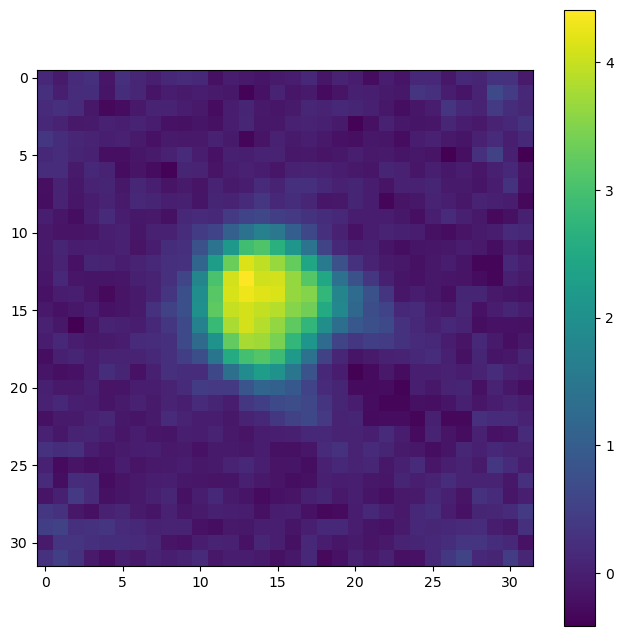

In [39]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec[:, :, 0]))))
plt.colorbar()

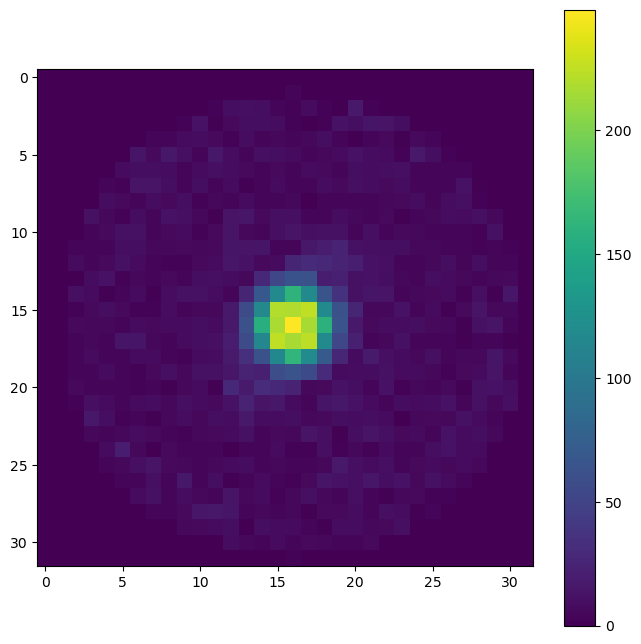

In [40]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:, :, 0])))
plt.colorbar()

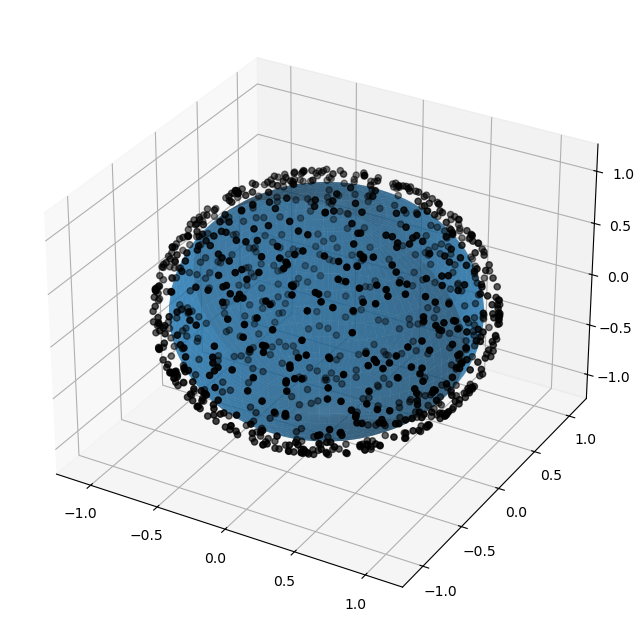

In [41]:
plot_angles(angles_rec[0,:1000])

mean shift error = 2.510762518921207 in [ -10 , 10 ]^2


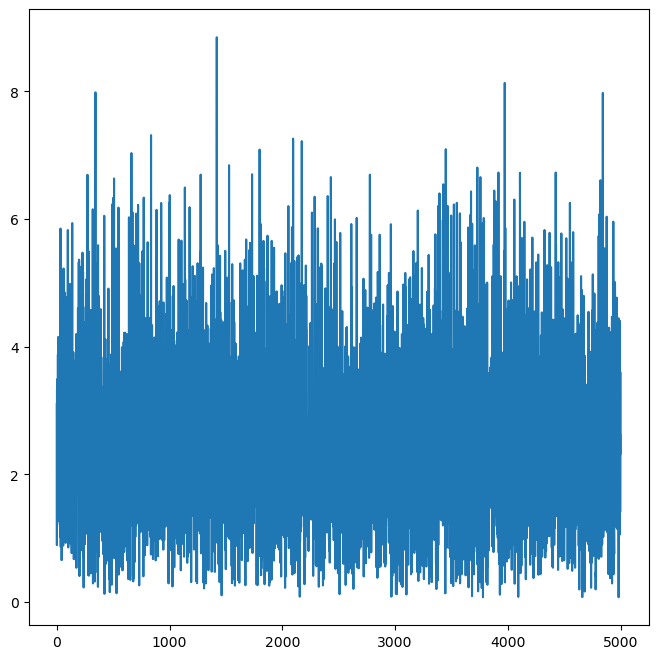

In [42]:
shifts_err = wrap_around_distance_2d_array(shifts_true, shifts_rec[0], 10)
print("mean shift error =", jnp.mean(shifts_err), "in [", -10, ",", 10, "]^2")
plt.plot(shifts_err)

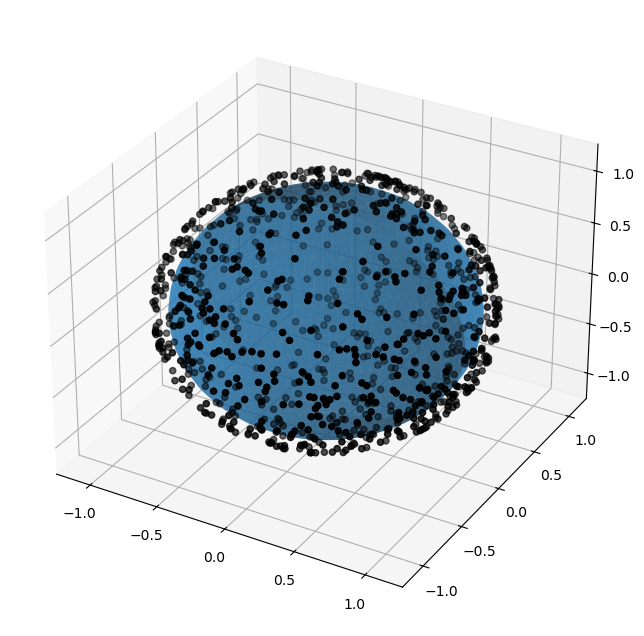

In [43]:
plot_angles(angles_true[:1000])